In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [3]:
df_join = pd.read_excel('../data/data_joined_16-23_no_new_buildings.xlsx')

In [4]:
df_infl = pd.read_excel('../data/constructed/inflation-rate-in-kazakhstan-2028.xlsx', sheet_name='Data')
df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))
df_infl=df_infl[pd.to_numeric(df_infl.Year)>=2016]

C:\Users\User\AppData\Local\Temp\ipykernel_20260\1026236143.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))


In [323]:

def get_perc_from_base(row):
    if row['Year'] == 2016:
        return 1.0
    else:
        return (1+row['Value']/100)

df_infl['Multiplier'] = df_infl.apply(lambda x: get_perc_from_base(x),axis=1)

for elem in range(18, 18 + df_infl.__len__()):
    if elem != 18:
        df_infl.at[elem,'Multiplier'] = df_infl.at[elem,'Multiplier']*df_infl.at[elem-1,'Multiplier']
    
df_join = df_join.merge(df_infl[['Year','Multiplier']], left_on='YEAR',right_on='Year').drop(columns=['Year'])

C:\Users\User\AppData\Local\Temp\ipykernel_7460\1967267119.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))


In [324]:
onehot = OneHotEncoder(sparse_output=False).fit(df_join[['Regions']])

df_join = df_join.join(pd.DataFrame(onehot.transform(df_join[['Regions']]), columns=onehot.get_feature_names_out()))

ValueError: columns overlap but no suffix specified: Index(['Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib'],
      dtype='object')

In [ ]:
df_join['price_adj'] = df_join['price']/df_join['Multiplier']
df_join['price_adj_per_area'] = df_join['price_adj']/df_join['area']
df_join['price_per_area'] = df_join['price']/df_join['area']

In [8]:
df_join.columns

Index(['Unnamed: 0', 'area', 'price', 'floor', 'year_built', 'region',
       'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions', 'Multiplier',
       'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area'],
      dtype='object')

In [9]:
df_join.YEAR.value_counts()

2020    59756
2023    26590
2017    22916
2021    18991
2019     1211
2022      135
2016       91
2018       23
Name: YEAR, dtype: int64

try 2016 x 2017 x 2018 vs 2019

In [5]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor

In [12]:
df_join.columns

Index(['Unnamed: 0', 'area', 'price', 'floor', 'year_built', 'region',
       'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions', 'Multiplier',
       'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area'],
      dtype='object')

In [ ]:
df_join['year_built'] = df_join.year_built.apply(lambda x: int(x[:x.find(' ')]) if type(x)==str else x)

Age of the building will make more sence with respect to the age of the data collected

In [ ]:
df_join['building_age'] = df_join['YEAR'] - df_join['year_built']

<AxesSubplot: ylabel='price_adj_per_area'>

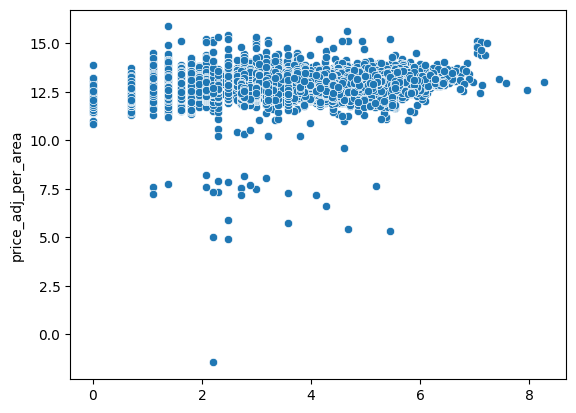

In [106]:
sns.scatterplot(x=np.log(df_join[(df_join['floor']>0)&(df_join['total_floor']>0)].floor * df_join[(df_join['floor']>0)&(df_join['total_floor']>0)].total_floor), y=np.log(df_join[(df_join['floor']>0)&(df_join['total_floor']>0)]['price_adj_per_area']))

In [123]:
df_join.groupby('YEAR')['price_adj_per_area'].mean()

YEAR
2016    336352.702794
2017    337483.304702
2018    317909.770735
2019    350714.733540
2020    353184.788808
2021    451746.977408
2022    426311.469469
2023    394282.503888
Name: price_adj_per_area, dtype: float64

In [129]:
df_join.groupby('YEAR', as_index=False).apply(lambda x: x.sample(20)).groupby('YEAR')['price_adj_per_area'].mean()

YEAR
2016    308710.061531
2017    311588.497417
2018    323402.617644
2019    316790.692254
2020    343861.936955
2021    460104.251066
2022    469352.600333
2023    355949.533048
Name: price_adj_per_area, dtype: float64

Index(['Unnamed: 0.1', 'Unnamed: 0', 'area', 'price', 'floor', 'year_built',
       'region', 'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions',
       'Multiplier', 'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area', 'building_age',
       'log_price_adj_per_area'],
      dtype='object')

In [132]:
df_infl

,Year,Value,Unit
18,2016,14.56,in %
19,2017,7.43,in %
20,2018,6.03,in %
21,2019,5.24,in %
22,2020,6.80,in %
23,2021,8.00,in %
24,2022,14.96,in %
25,2023,14.83,in %
26,2024,8.55,in %
27,2025,6.19,in %


In [197]:
sample_means = df_join.groupby('YEAR', as_index=False).apply(lambda x: x.sample(20)).groupby('YEAR')['price_adj_per_area'].mean()

def get_extrapolated_mean_price_per_area_adj(row):
    if row['YEAR'] != 2016:
        collected_mean = sample_means[row['YEAR']]
        infl = df_infl[df_infl['Year']==row['YEAR']]['Value'].item()
        infl = 1 + infl/100
        return collected_mean * infl
    else: return sample_means[row['YEAR']]


In [198]:
df_join['extrapolated_mean_price_adj_per_area'] = df_join.apply(lambda x: get_extrapolated_mean_price_per_area_adj(x), axis=1)

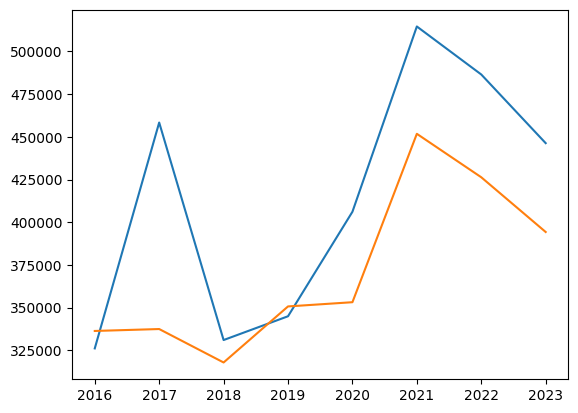

In [199]:
plt.plot(df_join.groupby('YEAR')[['extrapolated_mean_price_adj_per_area', 'price_adj_per_area']].mean())

In [6]:
PREDICTION_YEAR = 2023

In [265]:
x_train, y_train = df_join[df_join['YEAR'].isin(range(PREDICTION_YEAR-2, PREDICTION_YEAR))][[ 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'].isin(range(PREDICTION_YEAR-2, PREDICTION_YEAR))]['price_adj_per_area']

In [266]:
x_test, y_test = df_join[df_join['YEAR'] == PREDICTION_YEAR][[ 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'] == PREDICTION_YEAR]['price_adj_per_area']


In [238]:
from sklearn.preprocessing import StandardScaler

In [242]:
y_train, y_test = StandardScaler().fit_transform(y_train.to_numpy().reshape(-1, 1)), StandardScaler().fit_transform(y_test.to_numpy().reshape(-1, 1))

In [228]:
y_train, y_test = np.log(y_train), np.log(y_test)

Sent no cold entry data 

Decision Tree

In [245]:
maxv = (0,0)
iter_influence = []
for iter in range(2, 100):
    y_pred = DecisionTreeRegressor(max_leaf_nodes=iter).fit(x_train, y_train).predict(x_test)
    y_pred *= sample_means[PREDICTION_YEAR]/sample_means[x_test['YEAR']]
    score = R2Score()(torch.tensor(y_pred.to_numpy().flatten()), torch.tensor(y_test.flatten())).item()
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [246]:
maxv

(18, 0.3947216868400574)

In [204]:
maxv = (0,0)
iter_influence = []
for iter in range(2, 100):
    score = DecisionTreeRegressor(max_leaf_nodes=iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [205]:
maxv

(12, 0.22095311576542553)

<AxesSubplot: >

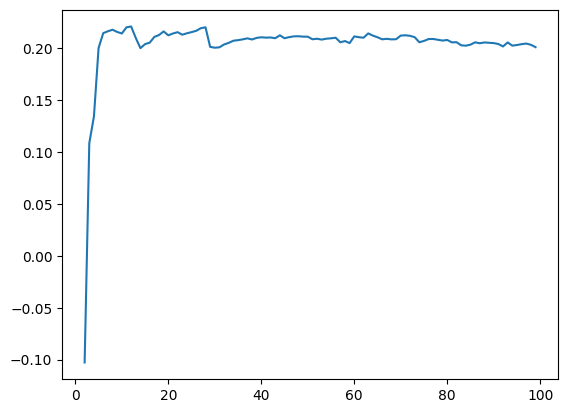

In [206]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

RandomForest

In [247]:
maxv = (0,0)
for iter in range(2, 20):
    score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
    if score > maxv[1]:
        maxv = (iter, score) 

C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\

In [249]:
maxv

(18, 0.4041998924266875)

Ada Boost # covered on ML course

In [141]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(1000, 10000, 100):
    score = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 6),n_estimators=iter, learning_rate=1/iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

KeyboardInterrupt: 

In [142]:
maxv

(1000, 0.21485095020045142)

<AxesSubplot: >

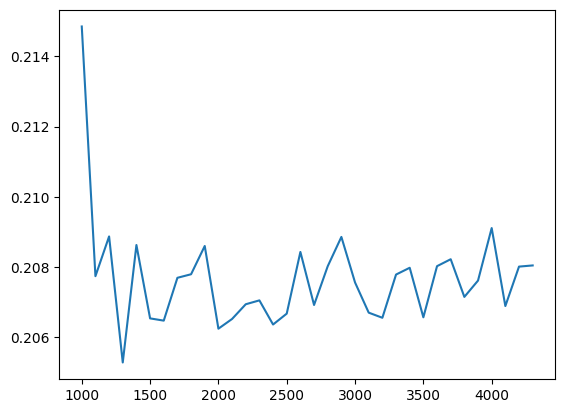

In [143]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Okey lets see what Gradient Boosting will show

In [7]:
from functools import lru_cache

In [35]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(1000, 1010, 10):
    score = GradientBoostingRegressor(n_estimators=iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [36]:
maxv

(1000, 0.36402903380809104)

<AxesSubplot: >

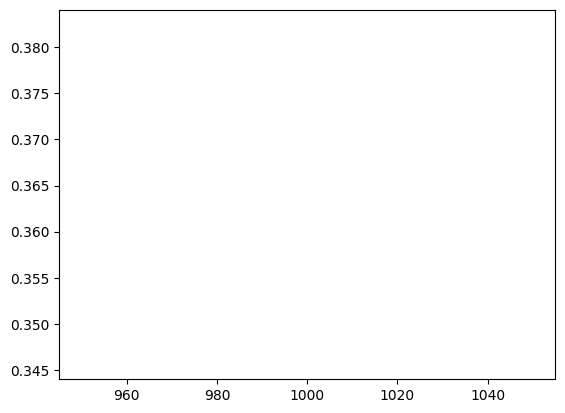

In [37]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Bagging

In [148]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(2, 11, 1):
    score = BaggingRegressor(DecisionTreeRegressor(max_leaf_nodes=iter),n_estimators=1000).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [149]:
maxv

(10, 0.23682812781575535)

<AxesSubplot: >

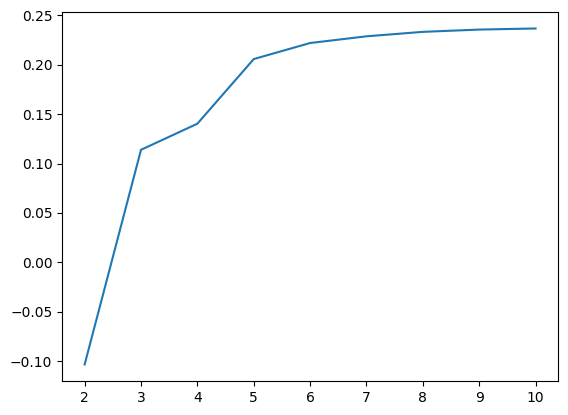

In [150]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Neural Network

In [8]:
from sklearn.neural_network import MLPRegressor

In [191]:
nn=MLPRegressor((8, 4),solver='adam', max_iter=50, verbose=True).fit(x_train, y_train)


Iteration 1, loss = 107.02969257
Iteration 2, loss = 4.94695276
Iteration 3, loss = 2.16431441
Iteration 4, loss = 1.69428506
Iteration 5, loss = 1.34494965
Iteration 6, loss = 1.14248808
Iteration 7, loss = 1.00995856
Iteration 8, loss = 0.80245269
Iteration 9, loss = 0.74396877
Iteration 10, loss = 0.70143993
Iteration 11, loss = 0.65794299
Iteration 12, loss = 0.61799723
Iteration 13, loss = 0.58672258
Iteration 14, loss = 0.55321374
Iteration 15, loss = 0.51832050
Iteration 16, loss = 0.48283745
Iteration 17, loss = 0.46167903
Iteration 18, loss = 0.43811273
Iteration 19, loss = 0.40334696
Iteration 20, loss = 0.39179977
Iteration 21, loss = 0.38296920
Iteration 22, loss = 0.34712197
Iteration 23, loss = 0.35875777
Iteration 24, loss = 0.31751400
Iteration 25, loss = 0.29696406
Iteration 26, loss = 0.30097190
Iteration 27, loss = 0.29456087
Iteration 28, loss = 0.30187876
Iteration 29, loss = 0.25066968
Iteration 30, loss = 0.27304400
Iteration 31, loss = 0.23655977
Iteration 32, l

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [192]:
nn.score(x_test, y_test)

0.42474515112197253

In [214]:
df_join['log_price_adj_per_area'] = np.log(df_join.price_adj_per_area)

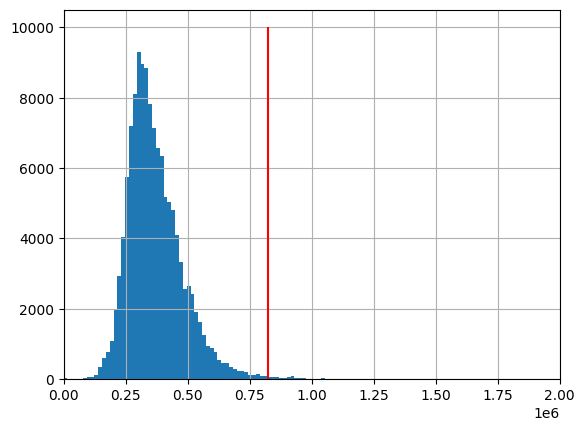

In [213]:
df_join.price_adj_per_area.hist(bins=500)

plt.xlim((0,2e6))

plt.vlines(x=df_join.price_adj_per_area.mean()+df_join.price_adj_per_area.std()*3.4, ymin=0, ymax=1e4, colors='red')

In [9]:
import torch
from torch import nn


In [251]:
x_test.shape

(26590, 15)

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 4)
        # self.fc3 = nn.Linear(16, 8)
        self.out = nn.Linear(4, 1)
    
    def forward(self, x):
        copy = x.copy()
        if type(copy) == pd.DataFrame:
            copy = torch.tensor(copy.values).float()
        copy = nn.functional.relu(self.fc1(copy))
        copy = nn.functional.relu(self.fc2(copy))
        # copy = nn.functional.relu(self.fc3(copy))
        return self.out(copy)



In [18]:
model = Model()

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [20]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()

array([[58000000],
       [42500000],
       [48000000],
       ...,
       [26000000],
       [61200000],
       [70000000]], dtype=int64)

In [33]:
for epoch in range(10000):

    optimizer.zero_grad()
    
    y_pred = model(x_train)
    loss = criterion(y_pred.flatten(),  torch.tensor(y_train.flatten()))
    r2score = R2Score()(y_pred.flatten(),  torch.tensor(y_train.flatten()))
    loss.backward()
    optimizer.step()


    print(f'[{epoch + 1}] loss: {loss.item():.3f}', 'R^2', r2score.item())


[1] loss: 2194193430609920.000 R^2 -0.9660797119140625
[2] loss: 2194193027956736.000 R^2 -0.9660793542861938
[3] loss: 2194192759521280.000 R^2 -0.9660791158676147
[4] loss: 2194192222650368.000 R^2 -0.9660786390304565
[5] loss: 2194192088432640.000 R^2 -0.966078519821167
[6] loss: 2194191685779456.000 R^2 -0.9660781621932983
[7] loss: 2194191551561728.000 R^2 -0.9660780429840088
[8] loss: 2194191014690816.000 R^2 -0.9660775661468506
[9] loss: 2194190880473088.000 R^2 -0.966077446937561
[10] loss: 2194190477819904.000 R^2 -0.9660770893096924
[11] loss: 2194189940948992.000 R^2 -0.9660766124725342
[12] loss: 2194189672513536.000 R^2 -0.9660763740539551
[13] loss: 2194189269860352.000 R^2 -0.9660760164260864
[14] loss: 2194189135642624.000 R^2 -0.9660758972167969
[15] loss: 2194188732989440.000 R^2 -0.9660755395889282
[16] loss: 2194188330336256.000 R^2 -0.9660751819610596
[17] loss: 2194188061900800.000 R^2 -0.9660749435424805
[18] loss: 2194187793465344.000 R^2 -0.9660747051239014
[19

In [21]:
from torchmetrics import R2Score

In [ ]:
with torch.no_grad():
        y_pred = model(x_test)
        loss = criterion(y_pred.flatten(),  torch.tensor(y_test.flatten()))
        r2score = R2Score()(y_pred.flatten(),  torch.tensor(y_test.flatten()))
        print('Loss Mae',loss.item())
        print('R^2', r2score.item())


Loss Mae 0.5007797888013856
R^2 0.21607857942581177


In [319]:
df_join.to_excel('../data/data_joined_16-23_no_new_buildings.xlsx')

In [320]:
df_join.shape

(129713, 26)

In [10]:
import torch
from torch import nn
from torchmetrics import R2Score

In [380]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 2)
        self.fc2 = nn.Linear(2, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = nn.functional.relu(self.fc1(output))
        output = nn.functional.relu(self.fc2(output))
        return output


In [11]:
x_train, y_train = df_join[df_join['YEAR'].isin(range(2016, PREDICTION_YEAR))][['area', 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'].isin(range(2016, PREDICTION_YEAR))]['price']

x_test, y_test = df_join[df_join['YEAR'] == PREDICTION_YEAR][['area', 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'] == PREDICTION_YEAR]['price']


In [1]:
input_size = x_train.shape[1]
hidden_size = 6
num_layers = 2
output_size = 1
model = RNN(input_size, hidden_size,num_layers, output_size)

NameError: name 'x_train' is not defined

In [392]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [393]:
num_epochs = 100
batch_size = 1

train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train.values).float(), torch.tensor(y_train.values).float().view(-1, output_size))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_r2 = 0.0
    num_batches = int(np.ceil(len(torch.tensor(x_train.values).float()) / batch_size))
    
    for batch_inputs, batch_targets in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        # r2score = R2Score()(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # epoch_r2 += r2score.item()
    
    
    avg_loss = epoch_loss / num_batches
    # avg_r2 = epoch_r2 / num_batches
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f} | R^2: {avg_r2:.2f}")

Epoch [1/100], Loss: 2191481439298204.2500
Epoch [2/100], Loss: 2172732426667992.5000
Epoch [3/100], Loss: 2137471837838764.0000
Epoch [4/100], Loss: 2086068504184629.2500
Epoch [5/100], Loss: 2022239906496578.7500
Epoch [6/100], Loss: 1947008643103037.5000
Epoch [7/100], Loss: 1864360075834316.0000
Epoch [8/100], Loss: 1776923157793377.5000
Epoch [9/100], Loss: 1689452905266495.5000
Epoch [10/100], Loss: 1603042120715810.2500
Epoch [11/100], Loss: 1522393987507085.0000
Epoch [12/100], Loss: 1447992347639845.0000
Epoch [13/100], Loss: 1381095582755898.2500
Epoch [14/100], Loss: 1323859293867130.5000
Epoch [15/100], Loss: 1277142976572955.5000
Epoch [16/100], Loss: 1238184640799221.5000
Epoch [17/100], Loss: 1208074693537861.0000
Epoch [18/100], Loss: 1184174665215498.7500
Epoch [19/100], Loss: 1166028061613518.7500
Epoch [20/100], Loss: 1152360648330473.5000
Epoch [21/100], Loss: 1142294201799112.2500
Epoch [22/100], Loss: 1134941269066657.7500
Epoch [23/100], Loss: 1129530863276535.25

KeyboardInterrupt: 

In [394]:
with torch.no_grad():
        y_pred = model(torch.tensor(x_test.values).float())
        loss = criterion(y_pred,  torch.tensor( torch.tensor(y_test.values).float().view(-1, output_size)))
        r2score = R2Score()(y_pred,  torch.tensor( torch.tensor(y_test.values).float().view(-1, output_size)))
        print('Loss mae',loss.item())
        print('R^2', r2score.item())


C:\Users\User\AppData\Local\Temp\ipykernel_10440\4218996702.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred,  torch.tensor( torch.tensor(y_test.values).float().view(-1, output_size)))
C:\Users\User\AppData\Local\Temp\ipykernel_10440\4218996702.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2score = R2Score()(y_pred,  torch.tensor( torch.tensor(y_test.values).float().view(-1, output_size)))


Loss mae 3414812264497152.0
R^2 -0.04205203056335449


In [373]:
with torch.no_grad():
        y_pred = model(torch.tensor(x_train.values).float())
        loss = criterion(y_pred,  torch.tensor( torch.tensor(np.log(y_train).values).float().view(-1, output_size)))
        r2score = R2Score()(y_pred,  torch.tensor( torch.tensor(np.log(y_train).values).float().view(-1, output_size)))
        print('Loss mse',loss.item())
        print('R^2', r2score.item())


Loss mse 0.11210433393716812
R^2 0.6979533433914185


C:\Users\User\AppData\Local\Temp\ipykernel_10440\3218660598.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred,  torch.tensor( torch.tensor(np.log(y_train).values).float().view(-1, output_size)))
C:\Users\User\AppData\Local\Temp\ipykernel_10440\3218660598.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2score = R2Score()(y_pred,  torch.tensor( torch.tensor(np.log(y_train).values).float().view(-1, output_size)))


In [36]:
df_join.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'area', 'price', 'floor', 'year_built',
       'region', 'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions',
       'Multiplier', 'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area', 'building_age',
       'log_price_adj_per_area'],
      dtype='object')

In [47]:
#time series cross valid
scores = []
for year in range(2018, 2024):

        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)][['building_age',
         'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)]['price'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
                'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
                'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
                'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = np.log(df_join[df_join['YEAR']==year]['price'])
                
        scores.append(BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),n_estimators=10).fit(x_train, y_train).score(x_test,y_test))

In [48]:
scores

[0.7154128840559537,
 0.5719494345411051,
 0.40122024364207864,
 0.1116504821861315,
 0.5824050774219953,
 0.5310896833190861]

In [49]:
#time series cross valid
scores = []
for year in range(2018, 2024):

        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)][['building_age',
         'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)]['price_adj'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
                'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
                'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
                'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = np.log(df_join[df_join['YEAR']==year]['price_adj'])
                
        scores.append(BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),n_estimators=10).fit(x_train, y_train).score(x_test,y_test))

In [50]:
scores

[0.5788261453071228,
 0.6242969693258604,
 0.4241190789808075,
 0.2829169172646785,
 0.55838321868537,
 0.5137163077051705]

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [54]:
#time series cross valid
scores = []
mses = []
maes = []
mapes = []
for year in range(2018, 2024):

        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)][['building_age',
         'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)]['price_adj'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
                'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
                'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
                'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = np.log(df_join[df_join['YEAR']==year]['price_adj'])

        model = BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),n_estimators=10).fit(x_train, y_train)
        scores.append(model.score(x_test,y_test))
        y_pred = model.predict(x_test)
        mses.append(mean_squared_error(y_pred, y_test))
        maes.append(mean_absolute_error(y_pred, y_test))
        mapes.append(mean_absolute_percentage_error(y_pred, y_test))

print('TIMESERIES CV PERFORMANCE')
print('R^2', np.mean(scores))
print('MSE', np.mean(mses))
print('RMSE', np.mean(mses)**0.5)
print('MAE', np.mean(maes))
print('MAPE', np.mean(mapes)) 

TIMESERIES CV PERFORMANCE
R^2 0.5289038517625818
MSE 0.17952278143498687
RMSE 0.4237012879789096
MAE 0.317044613206761
MAPE 0.018696695772554766


In [58]:
#time series cross valid
scores = []
mses = []
maes = []
mapes = []
for year in range(2018, 2024):
        
        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015) & (df_join)][['building_age',
         'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = (df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)]['price_adj'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
                'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
                'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
                'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = (df_join[df_join['YEAR']==year]['price_adj'])

        model = BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),n_estimators=10).fit(x_train, y_train)
        scores.append(model.score(x_test,y_test))
        y_pred = model.predict(x_test)
        mses.append(mean_squared_error(y_pred, y_test))
        maes.append(mean_absolute_error(y_pred, y_test))
        mapes.append(mean_absolute_percentage_error(y_pred, y_test))

print('TIMESERIES CV PERFORMANCE')
print('R^2', np.mean(scores))
print('MSE', np.mean(mses))
print('RMSE', np.mean(mses)**0.5)
print('MAE', np.mean(maes))
print('MAPE', np.mean(mapes)) 

TIMESERIES CV PERFORMANCE
R^2 0.18395752000900567
MSE 558359602886454.56
RMSE 23629633.998148482
MAE 11192089.935337013
MAPE 0.33842810052792727


In [63]:
df_join.price.median() + 3 * (df_join.price.quantile(0.75) - df_join.price.quantile(0.25))

93223997.0

In [64]:
df_join.groupby('YEAR').price_adj.mean()

YEAR
2016    2.736032e+07
2017    2.491827e+07
2018    2.188738e+07
2019    3.144098e+07
2020    2.457886e+07
2021    3.186586e+07
2022    3.599341e+07
2023    2.862945e+07
Name: price_adj, dtype: float64

In [77]:

#time series cross valid
scores = []
mses = []
maes = []
mapes = []
for year in range(2018, 2024):
        
        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)][['building_age',
         'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>=2015)]['price_adj'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
                'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
                'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
                'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = np.log(df_join[df_join['YEAR']==year]['price_adj'])

        nn=MLPRegressor((8, 4),solver='adam', max_iter=50).fit(x_train, y_train)

        scores.append(nn.score(x_test,y_test))
        y_pred = nn.predict(x_test)
        mses.append(mean_squared_error(y_pred, y_test))
        maes.append(mean_absolute_error(y_pred, y_test))
        mapes.append(mean_absolute_percentage_error(y_pred, y_test))

print('TIMESERIES CV PERFORMANCE')
print('R^2', np.mean(scores))
print('MSE', np.mean(mses))
print('RMSE', np.mean(mses)**0.5)
print('MAE', np.mean(maes))
print('MAPE', np.mean(mapes)) 